# blasé calibration with LFC fibers

The resolution seems off.  Let's calibrate blasé with the LFC spectra.

In [1]:
%config Completer.use_jedi = False

In [2]:
import torch
from blase.emulator import SparseLogEmulator, ExtrinsicModel, InstrumentalModel
import matplotlib.pyplot as plt
from gollum.phoenix import PHOENIXSpectrum
from gollum.telluric import TelFitSpectrum
from blase.utils import doppler_grid
import astropy.units as u
import numpy as np

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
    
%matplotlib inline
%config InlineBackend.figure_format='retina'

Woohoo! You have a version 1.13.0 of PyTorch


In [3]:
device

'cpu'

## Pre-process the data
We will quickly pre-process the HPF spectrum with the [muler](https://muler.readthedocs.io/en/latest/) library

In [4]:
from muler.hpf import HPFSpectrum

In [5]:
fn1 = '/Volumes/pecos/HPF/TACC/UT21-2-013/Goldilocks_20210801T064548_v1.0_0028.spectra.fits'

In [6]:
raw_data = HPFSpectrum(file=fn1, order=18) # 6, 14, 18

In [7]:
data = raw_data.sky_subtract().trim_edges().remove_nans().deblaze().normalize(normalize_by='peak')

In [8]:
# LFC Cal!!
fn2 = '/Volumes/pecos/HPF/TACC/CALS/CALS_Goldilocks_only/Goldilocks_20210801T063539_v1.0_0026.spectra.fits'

In [9]:
raw_data2 = HPFSpectrum(file=fn2, order=18)
data2 = raw_data2.sky_subtract().trim_edges().remove_nans().deblaze().normalize(normalize_by='peak')
data2.meta['header']['OBJECT']

'LFC Cal'

In [11]:
peak = data2.lfc.flux.max()

<AxesSubplot:title={'center':'HPF Spectrum'}, xlabel='$\\lambda \\;(\\AA)$', ylabel='Flux'>

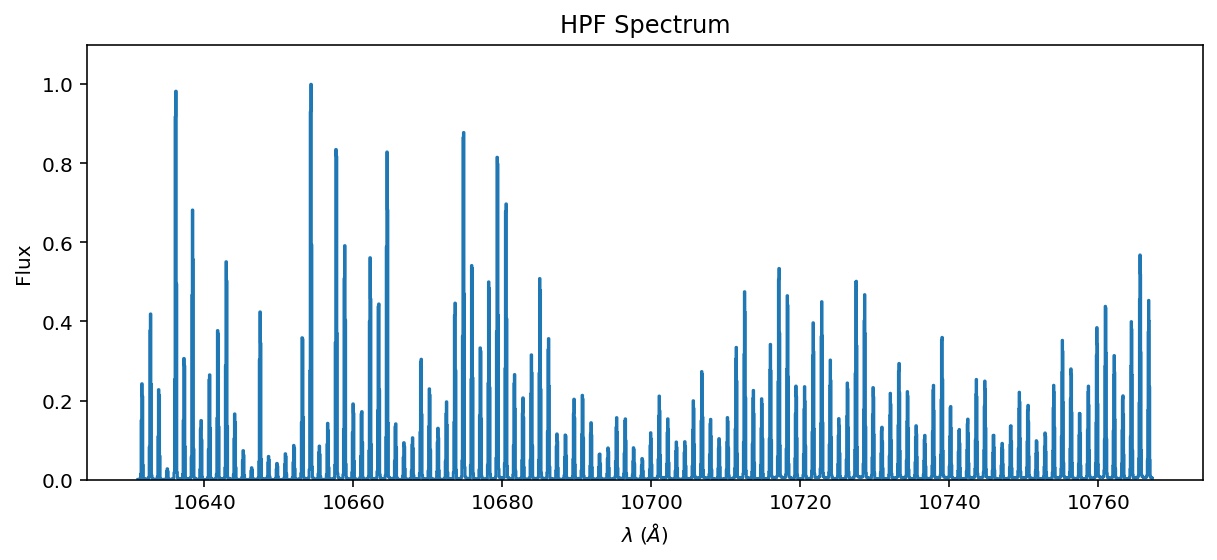

In [12]:
lfc = data2.lfc.divide(peak)

lfc.plot(yhi=1.1)

In [13]:
lfc.wavelength

<SpectralAxis 
   (observer to target:
      radial_velocity=0.0 km / s
      redshift=0.0)
  [10631.0559085 , 10631.13364969, 10631.21138121, ..., 10767.16465801,
   10767.21993086, 10767.27519185] Angstrom>

In [14]:
from scipy.signal import find_peaks

In [15]:
flux_vector = lfc.flux.value

In [16]:
peaks = find_peaks(flux_vector, distance=10, prominence=0.01)[0]

In [17]:
peak_coords = lfc.wavelength.value[peaks]

(-0.01, 0.01)

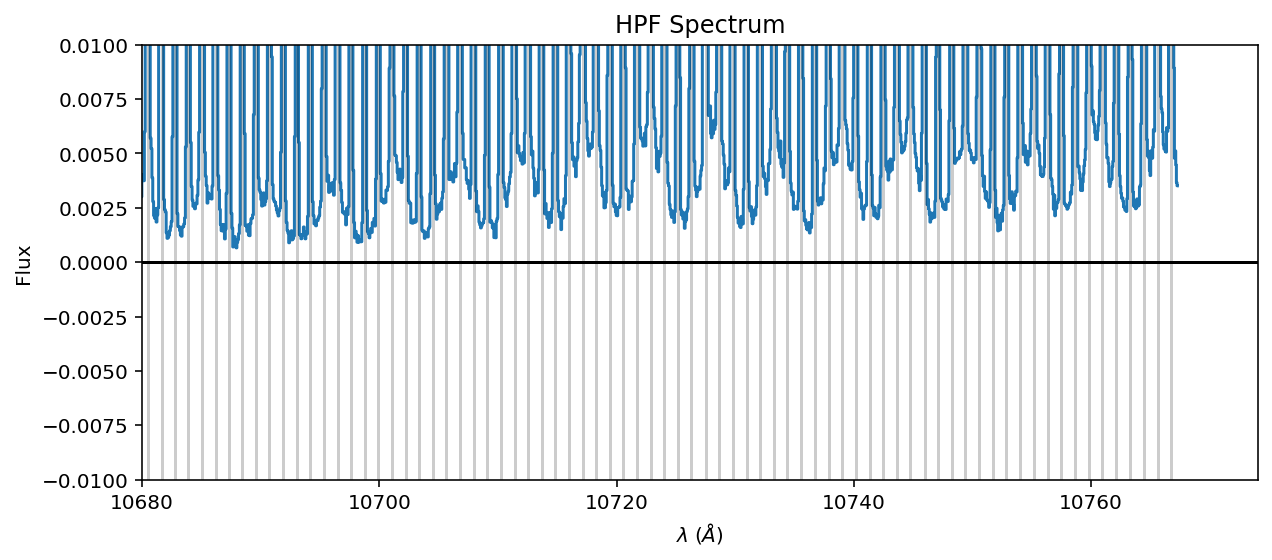

In [18]:
ax = lfc.plot(yhi=1.1)

for xv in peak_coords:
    ax.axvline(xv, linestyle='solid', alpha=0.2, color='k')
    
ax.axhline(0.0, color='k')
ax.set_xlim(10680)
ax.set_ylim(-0.01, 0.01)

Nice.

In [19]:
wl_lo = 10630-30.0
wl_hi = 10770+30.0
wavelength_grid = doppler_grid(wl_lo, wl_hi)

### Retrieve the Phoenix model

HAT-P-67 has $T_{\mathrm{eff}}=6406\;K$ and $\log{g}=3.854$, according to sources obtained through NASA Exoplanet Archive (Zhou et al. 2017 and references therein).  Let's start with a PHOENIX model possessing these properties.

In [20]:
spectrum = PHOENIXSpectrum(teff=6400, logg=4.0, wl_lo=wl_lo, wl_hi=wl_hi)
spectrum = spectrum.divide_by_blackbody()
spectrum = spectrum.normalize()
continuum_fit = spectrum.fit_continuum(polyorder=5)
spectrum = spectrum.divide(continuum_fit, handle_meta="ff")

### Retrieve the TelFit Telluric model

Let's pick a precomputed TelFit model with comparable temperature and humidity as the data.  You can improve on your initial guess by tuning a TelFit model from scratch.  We choose to skip this laborious step here, but encourage practitioners to try it on their own.

### Clone the stellar and telluric model

In [21]:
stellar_emulator = SparseLogEmulator(spectrum.wavelength.value, 
                                     np.log(spectrum.flux.value), prominence=0.01, wing_cut_pixels=3000, device=device)
stellar_emulator.to(device)

/Users/mag3842/GitHub/blase/src/blase/emulator.py:378: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.target = torch.tensor(


Initializing a sparse model with 103 spectral lines


SparseLogEmulator()

### Fine-tune the clone

In [22]:
stellar_emulator.optimize(epochs=3, LR=0.01)

Training Loss: 0.00351469: 100%|██████████████████| 3/3 [00:00<00:00,  3.85it/s]


### Step 3: Extrinsic model

(Remap the stellar and telluric emulator to a standardized wavelength grid).

In [23]:
from blase.emulator import SparseLogEmissionEmulator

In [24]:
import copy

In [25]:
emission_dict = copy.deepcopy(stellar_emulator.state_dict())

In [26]:
n_lines = len(peak_coords)

### Guess and check

In [27]:
#target_ln_sigma = -4.5
#target_ln_gamma = -7.5

In [28]:
emission_dict['lam_centers'] = torch.tensor(peak_coords)
emission_dict['amplitudes'] = torch.repeat_interleave(torch.tensor(-3.0345), n_lines)
emission_dict['sigma_widths'] = torch.repeat_interleave(torch.tensor(-2.432), n_lines)
emission_dict['gamma_widths'] = torch.repeat_interleave(torch.tensor(-5.432), n_lines)

In [29]:
emission_model = SparseLogEmissionEmulator(wavelength_grid, 
                                     init_state_dict=emission_dict, wing_cut_pixels=100, device=device)

Initializing a sparse model with 119 spectral lines


In [30]:
with torch.no_grad():
    emission_spec = emission_model.forward()

(0.0, 0.6)

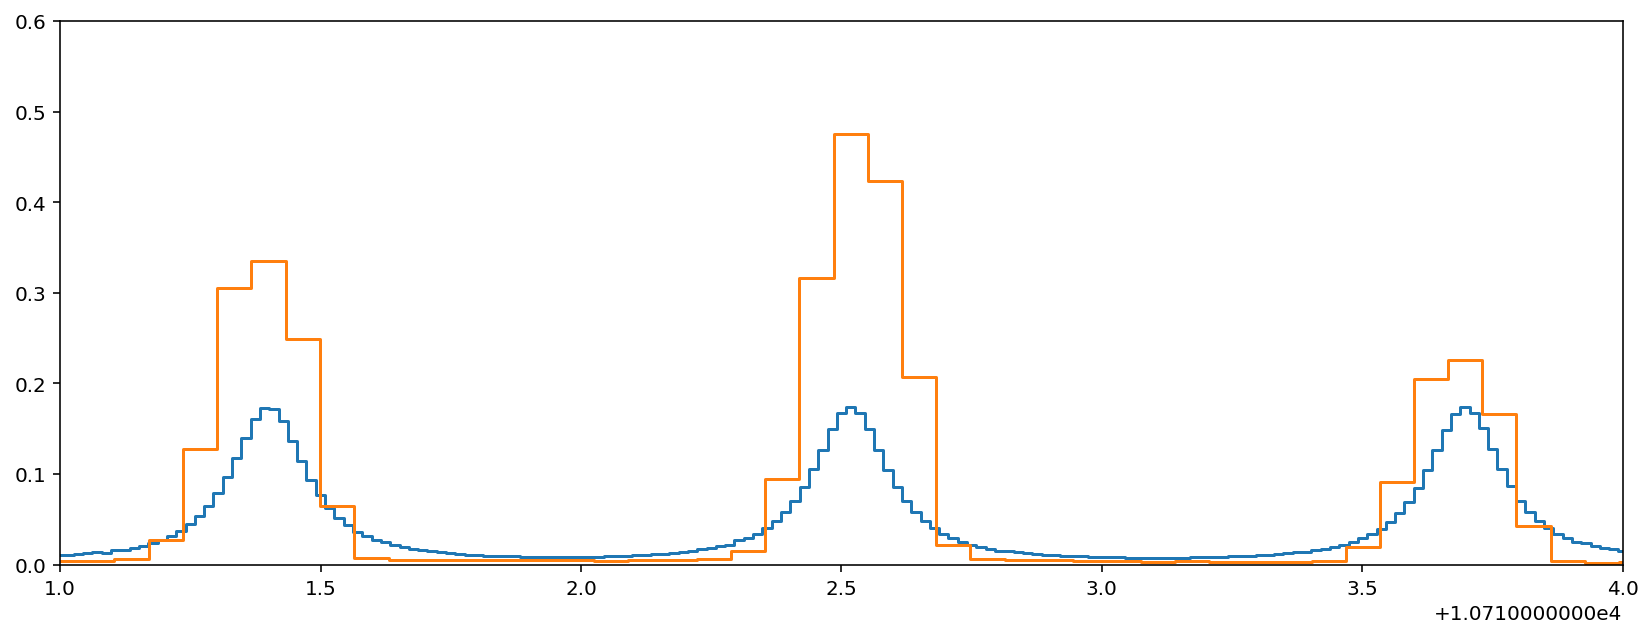

In [31]:
plt.figure(figsize=(14, 5))
plt.step(wavelength_grid, emission_spec, where='mid')
plt.step(lfc.wavelength, lfc.flux, where='mid')
plt.xlim(10711, 10714)
plt.ylim(0.0, 0.6)

In [32]:
emission_model.to(device)

SparseLogEmissionEmulator()

#### Forward model

#### Instrumental model

In [33]:
instrumental_model = InstrumentalModel(lfc.bin_edges.value, wavelength_grid, device=device)
instrumental_model.to(device)

InstrumentalModel(
  (linear_model): Linear(in_features=15, out_features=1, bias=True)
)

In [34]:
instrumental_model.ln_sigma_angs.data = torch.log(torch.tensor(0.064))

In [35]:
detector_flux = instrumental_model.forward(emission_spec)

(10640.0, 10680.0)

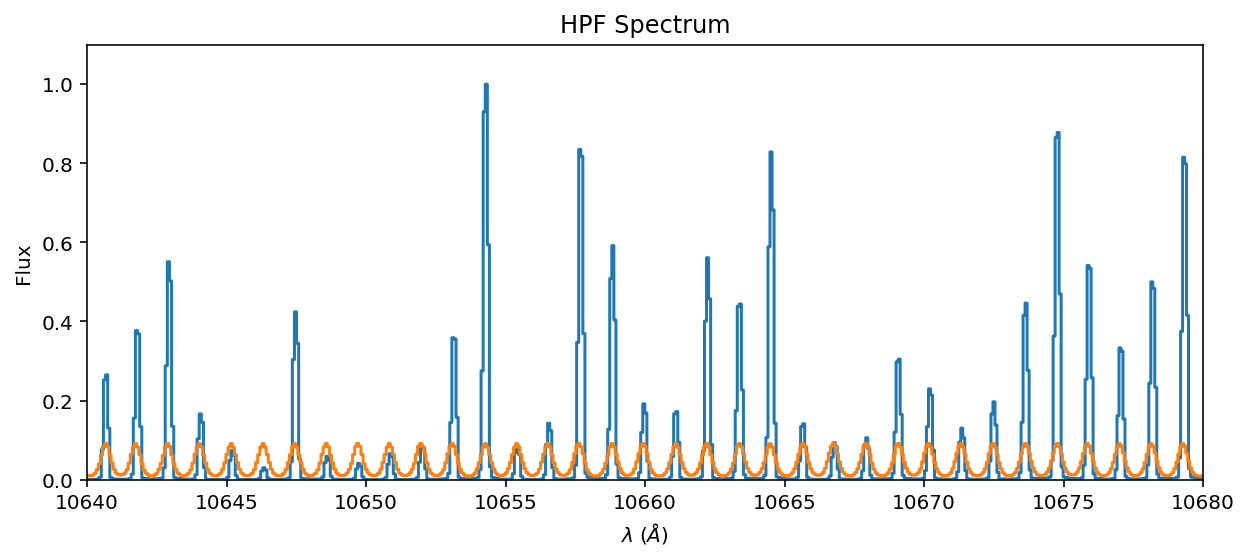

In [36]:
ax = lfc.plot(yhi=1.1)
ax.step(data.wavelength, detector_flux.detach().cpu().numpy());
ax.set_xlim(10640, 10680)

## Transfer learn a semi-empirical model

Here we compare the resampled joint model to the observed data to "transfer learn" underlying super resolution spectra.

In [37]:
from torch import nn
from tqdm import trange
import torch.optim as optim

In [38]:
data_target = torch.tensor(
    lfc.flux.value.astype(np.float64), device=device, dtype=torch.float64
)

data_wavelength = torch.tensor(
    lfc.wavelength.value.astype(np.float64), device=device, dtype=torch.float64
)

In [39]:
loss_fn = nn.MSELoss(reduction="mean")

### Fix certain parameters, allow others to vary
As we have seen before, you can fix parameters by "turning off their gradients".  We will start by turning off *ALL* gradients.  Then turn on some.

In [40]:
# Fix all stellar parameters except amplitude and RV
emission_model.amplitudes.requires_grad = True
emission_model.radial_velocity.requires_grad = False
emission_model.lam_centers.requires_grad = True
emission_model.sigma_widths.requires_grad = True
emission_model.gamma_widths.requires_grad = True
emission_model.a_coeff.requires_grad = False
emission_model.b_coeff.requires_grad = False
emission_model.c_coeff.requires_grad = False

# Fix all instrument parameters
instrumental_model.ln_sigma_angs.requires_grad = True
instrumental_model.linear_model.weight.requires_grad = True
instrumental_model.linear_model.bias.requires_grad = True


In [41]:
tuning_params = list(filter(lambda p: p.requires_grad, emission_model.parameters())) \
    + list(filter(lambda p: p.requires_grad, instrumental_model.parameters())) 

In [42]:
optimizer = optim.Adam(tuning_params,0.01,amsgrad=True)         

In [43]:
n_epochs = 1000
losses = []

## Regularization is fundamental

The blase model as it stands is **too flexible**.  It must have regularization to balance its propensity to overfit.

First, we need to assign uncertainty to the data in order to weigh the prior against new data:

In [44]:
# We need uncertainty to be able to compute the posterior
# Assert fixed per-pixel uncertainty for now
per_pixel_uncertainty = torch.tensor(0.01, device=device, dtype=torch.float64)

Then we need the prior.  For now, let's just apply priors on the amplitudes (almost everything else is fixed).  We need to set the regularization hyperparameter tuning.

In [45]:
amp_regularization = 2.1

In [46]:
import copy

In [47]:
#tightness = 0.1

# Define the prior on the amplitude
def ln_prior(sigma_widths, gamma_widths):
    """
    Prior for the amplitude vector
    """
    pass
    #sigma_diff = sigma_widths - target_ln_sigma
    #ln_prior1 = 0.5 * torch.sum((sigma_diff ** 2) / (tightness ** 2))
    
    #gamma_diff = gamma_widths - target_ln_gamma
    #ln_prior2 = 0.5 * torch.sum((gamma_diff ** 2) / (tightness ** 2))

    #return ln_prior1 + ln_prior2

In [48]:
t_iter = trange(n_epochs, desc="Training", leave=True)
for epoch in t_iter:
    emission_model.train()
    instrumental_model.train()
    
    flux = emission_model.forward()
    #detector_flux = instrumental_model.forward(flux)
    detector_flux = instrumental_model.resample_to_data(flux)
    
    loss = loss_fn(detector_flux / per_pixel_uncertainty, data_target / per_pixel_uncertainty)
    #loss += ln_prior(emission_model.sigma_widths, emission_model.gamma_widths)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    t_iter.set_description("Training Loss: {:0.8f}".format(loss.item()))

Training Loss: 1.32846774: 100%|████████████| 1000/1000 [00:32<00:00, 31.14it/s]


### Spot check the transfer-learned joint model

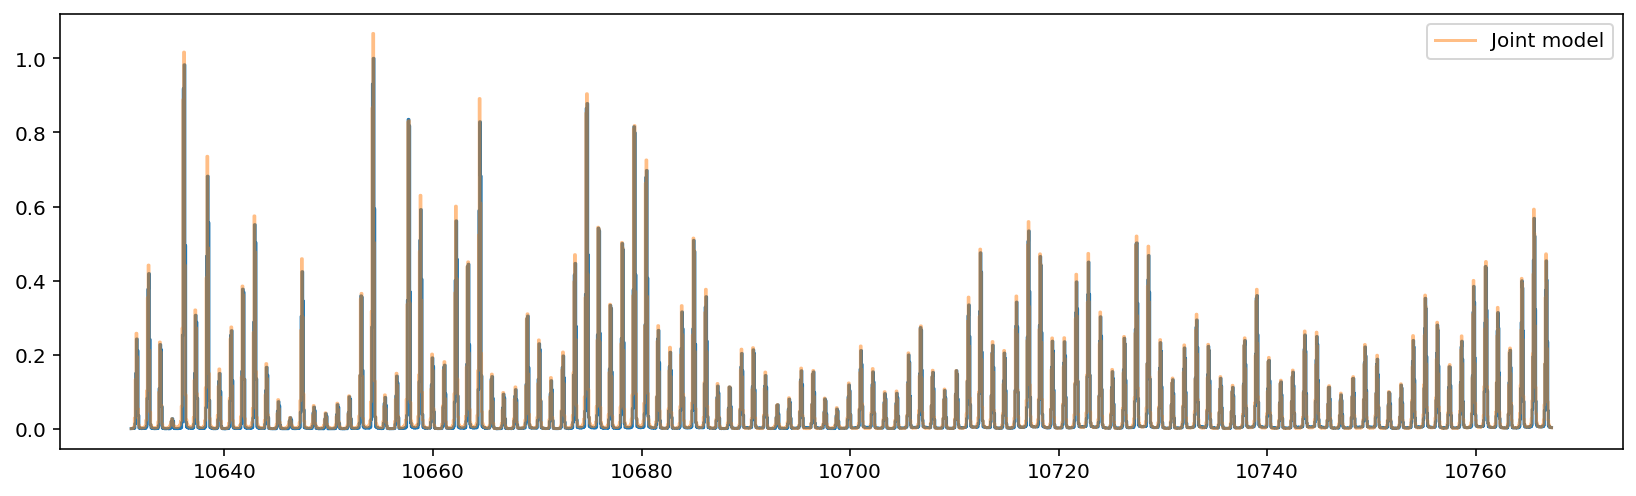

In [49]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.step(lfc.wavelength, lfc.flux, where='mid');
ax.step(lfc.wavelength, detector_flux.detach().cpu().numpy(), label='Joint model', alpha=0.5);
ax.legend()

Insight: we need to go to full exact Voigt rather than pseudoVoigt!

(10650.0, 10670.0)

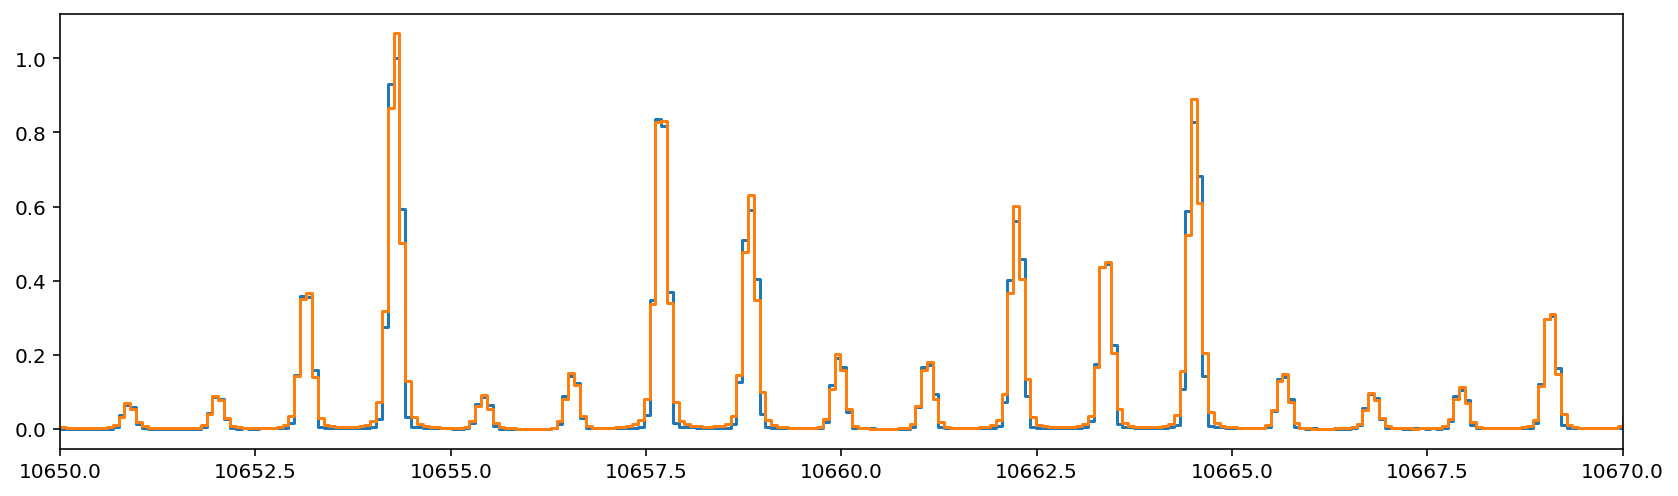

In [89]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.step(lfc.wavelength, lfc.flux, where='mid');
ax.step(lfc.wavelength, detector_flux.detach().cpu().numpy(), where='mid');
ax.set_xlim(10650, 10670)

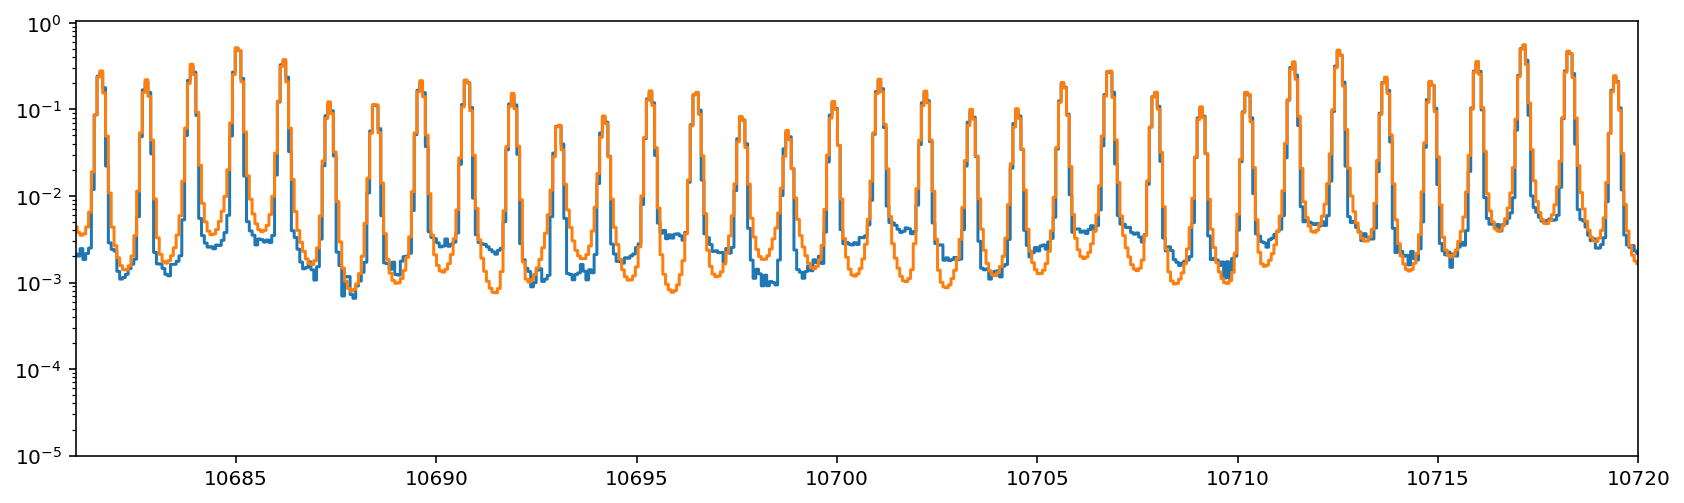

In [51]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.step(lfc.wavelength, lfc.flux, where='mid');
ax.step(lfc.wavelength, detector_flux.detach().cpu().numpy(), where='mid');
ax.set_xlim(10681, 10720)
ax.set_ylim(1e-5, 1.06)
plt.yscale('log')

### Inspect the individual stellar and telluric components

In [52]:
emission_model.wl_2D.shape

torch.Size([119, 100])

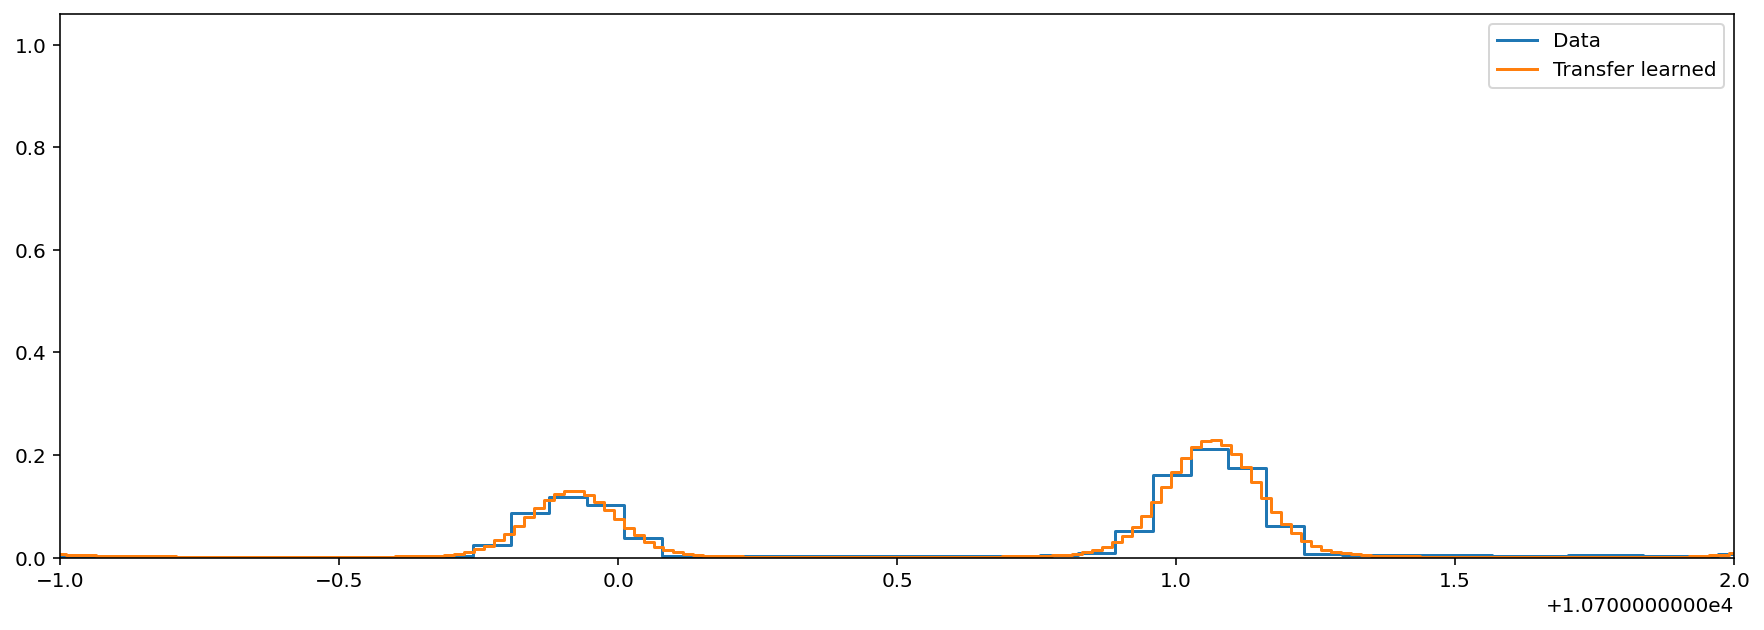

In [53]:
with torch.no_grad():
    high_res = emission_model.forward()

fig, ax = plt.subplots(figsize=(15, 5))
lfc.plot(ax=ax, label='Data')
ax.step(wavelength_grid, high_res, label='Transfer learned', where='mid');
ax.legend()
ax.set_xlim(10699, 10702)
ax.set_ylim(0, 1.06)
plt.yscale('linear')

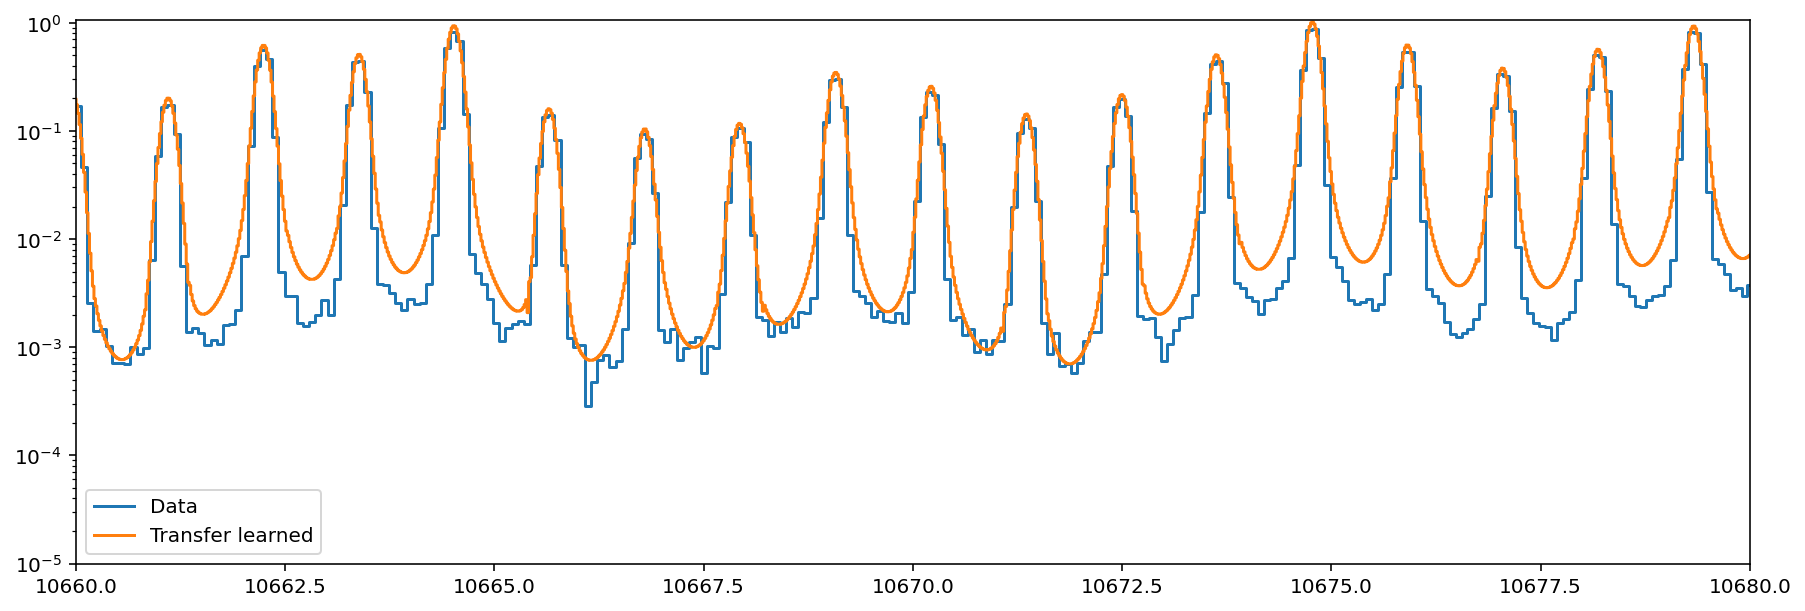

In [54]:
with torch.no_grad():
    high_res = emission_model.forward()

fig, ax = plt.subplots(figsize=(15, 5))
lfc.plot(ax=ax, label='Data')
ax.step(wavelength_grid, high_res, label='Transfer learned', where='mid');
ax.legend()
ax.set_xlim(10660, 10680)
ax.set_ylim(1e-5, 1.06)
plt.yscale('log')

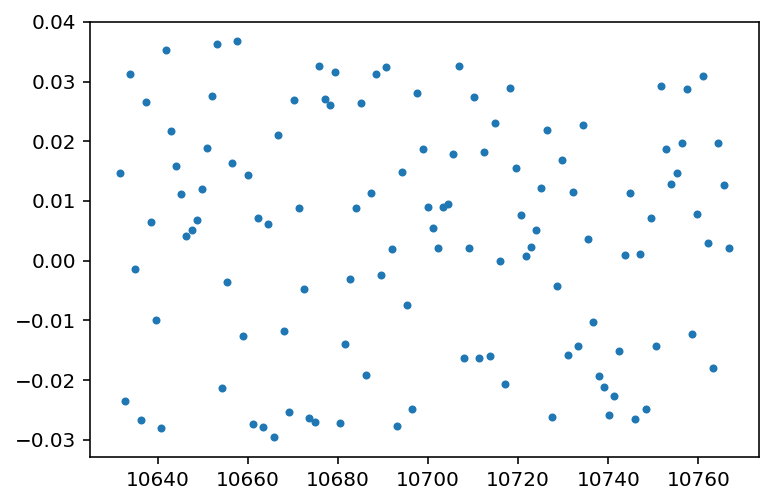

In [55]:
plt.plot(emission_dict['lam_centers'], 
         emission_model.lam_centers.detach()-emission_dict['lam_centers'], '.')

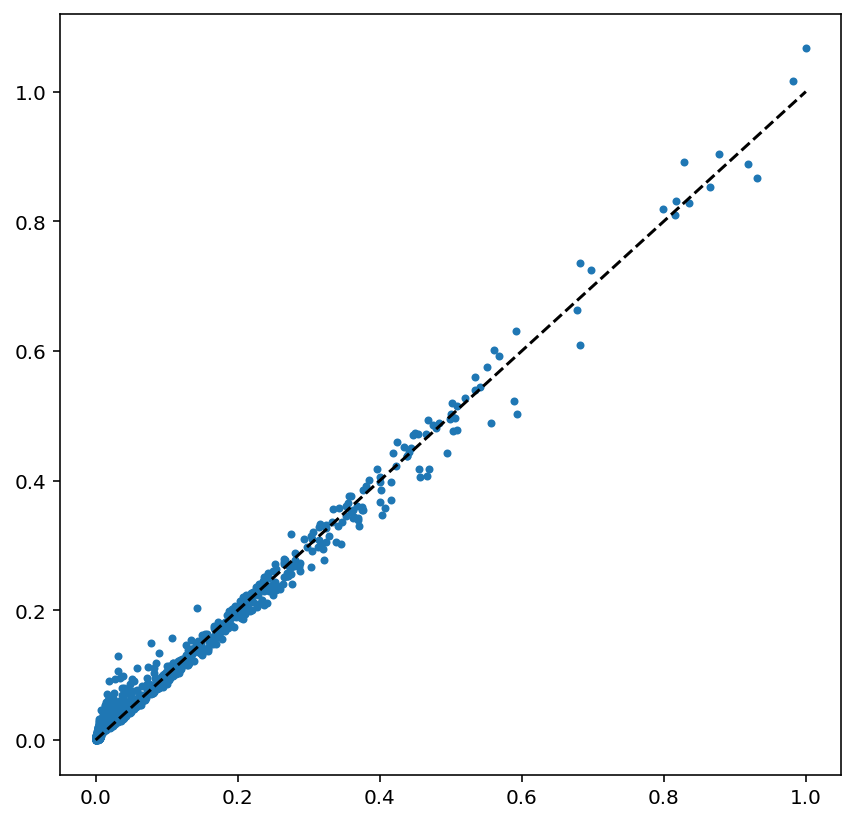

In [56]:
plt.figure(figsize=(7,7))
plt.plot(lfc.flux.value, 
         detector_flux.detach().cpu().numpy(), '.')
plt.plot([0,1], [0, 1], color='k', linestyle='dashed')

In [57]:
resid = lfc.flux.value - detector_flux.detach().cpu().numpy()

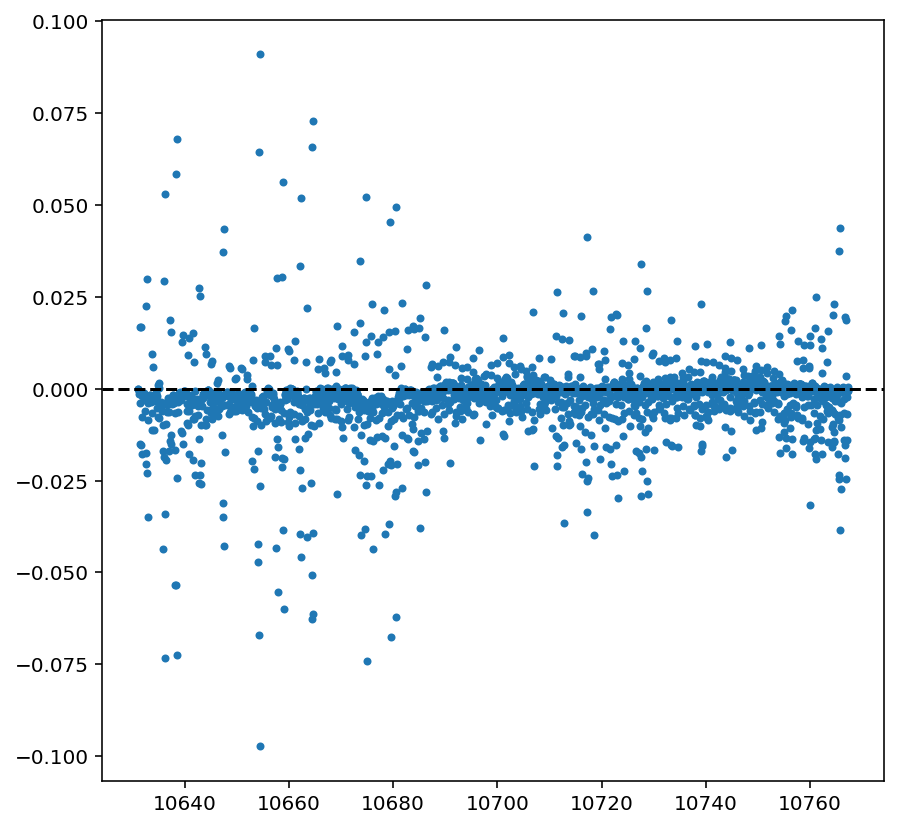

In [58]:
plt.figure(figsize=(7,7))
plt.plot(lfc.wavelength.value, resid, '.')
plt.axhline(0.0, linestyle='dashed', color='k')

In [59]:
np.std(resid)

0.011311568238522265

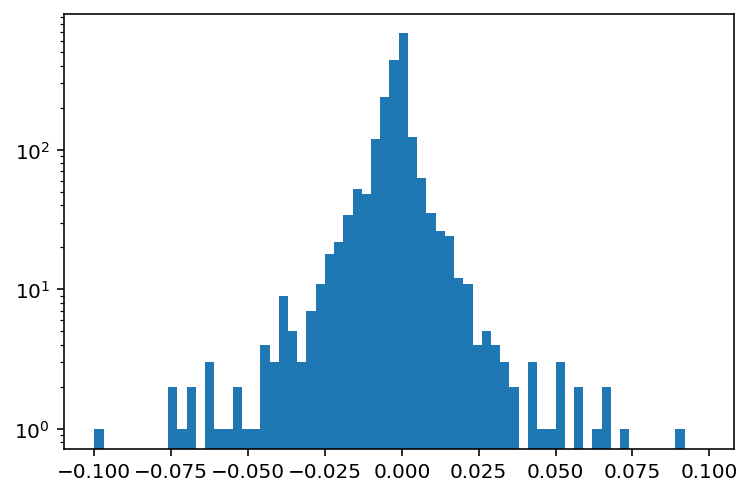

In [60]:
plt.hist(resid, bins=np.arange(-0.1, 0.1, 0.003));
plt.yscale('log')

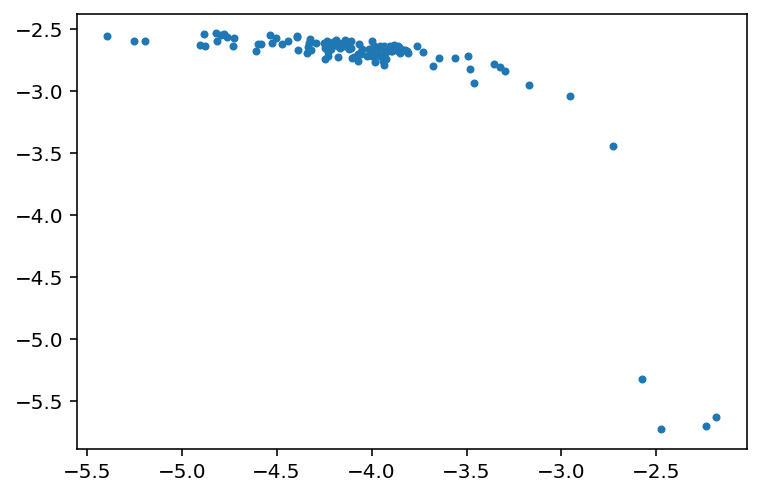

In [61]:
plt.plot(emission_model.sigma_widths.detach(), emission_model.gamma_widths.detach(), '.')

In [62]:
sig_shared = (0.01+torch.exp(instrumental_model.ln_sigma_angs.detach())) # But convolved with individual lines...

In [63]:
10680/(2.355*sig_shared)

tensor(61284.2070)

In [64]:
sig_indiv = torch.exp(emission_model.sigma_widths.detach())

In [65]:
torch.std(sig_indiv*2.355)

tensor(0.0388)

In [86]:
resolving_power = 10680/((2.355*sig_indiv) + 2*torch.exp(emission_model.gamma_widths.detach()))

In [87]:
resolving_power

tensor([64196.8789, 63234.0391, 65557.0859, 39288.5938, 63735.0156, 63775.5781,
        62769.0234, 66244.7891, 62615.8164, 62969.7812, 60923.1641, 66153.1719,
        55836.0664, 41449.2305, 61747.1250, 48937.7500, 52084.2266, 52494.1094,
        59185.6133, 61786.2930, 61109.9727, 57712.8594, 65652.6484, 63186.5508,
        60276.6562, 66187.6797, 63297.6602, 59757.3945, 60153.6133, 59800.7891,
        66125.2734, 58774.9414, 60272.4961, 59126.5859, 62562.3125, 65222.7500,
        62992.9766, 61333.7031, 61202.8516, 60998.1172, 61083.5156, 60279.2188,
        60157.6055, 59737.3438, 64077.2812, 62064.7227, 59485.4180, 58377.0859,
        58897.3828, 59876.5117, 59452.6602, 63495.5391, 61263.2852, 64332.9609,
        49041.4688, 51735.3398, 62998.6680, 61768.9883, 52145.6875, 56628.7070,
        59643.8906, 57612.4492, 60132.0312, 55779.4219, 55171.6094, 59444.2227,
        57181.0273, 61059.6172, 54320.9180, 61469.1133, 58624.0938, 56271.7305,
        58343.0117, 60250.4883, 57694.58

(0.0, 100000.0)

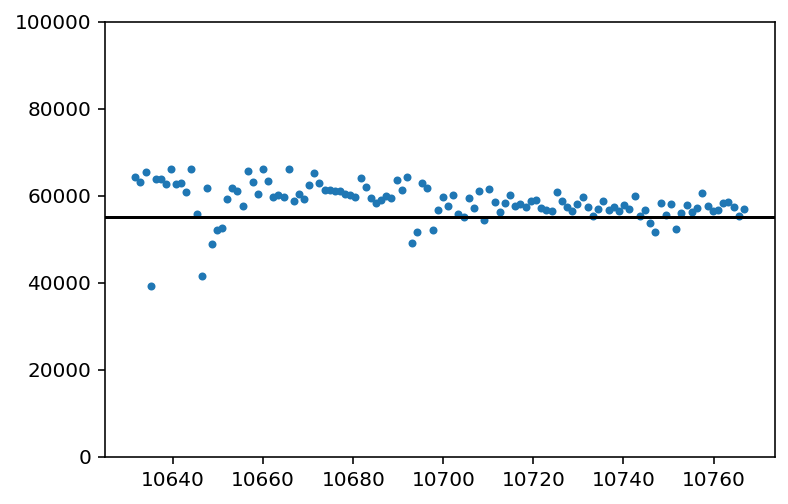

In [88]:
plt.plot(emission_model.lam_centers.detach(), resolving_power, '.')
plt.axhline(55_000, color='k')
plt.ylim(0, 100_000)

In [73]:
emission_model.lam_centers.detach()

tensor([10631.6174, 10632.7384, 10633.8812, 10635.0087, 10636.1414, 10637.2704,
        10638.4025, 10639.5373, 10640.6703, 10641.8047, 10642.9341, 10644.0701,
        10645.2070, 10646.3339, 10647.4711, 10648.6076, 10649.7383, 10650.8794,
        10652.0149, 10653.1453, 10654.2884, 10655.4211, 10656.5581, 10657.6921,
        10658.8285, 10659.9649, 10661.1051, 10662.2403, 10663.3838, 10664.5164,
        10665.6510, 10666.8002, 10667.9297, 10669.0779, 10670.2172, 10671.3558,
        10672.4962, 10673.6274, 10674.7739, 10675.9085, 10677.0466, 10678.1861,
        10679.3288, 10680.4773, 10681.6206, 10682.7621, 10683.8993, 10685.0416,
        10686.1882, 10687.3343, 10688.4695, 10689.6170, 10690.7617, 10691.9070,
        10693.0491, 10694.1919, 10695.3376, 10696.4831, 10697.6281, 10698.7762,
        10699.9190, 10701.0628, 10702.2099, 10703.3610, 10704.4980, 10705.6476,
        10706.7958, 10707.9471, 10709.0905, 10710.2399, 10711.3862, 10712.5364,
        10713.6802, 10714.8329, 10715.98

In [71]:
np.diff(emission_model.lam_centers.detach().numpy())

array([1.12101409, 1.1428088 , 1.12745806, 1.13273081, 1.12898688,
       1.13207552, 1.13483302, 1.13304693, 1.13434575, 1.12939766,
       1.13604354, 1.13689663, 1.12685252, 1.13724907, 1.13644039,
       1.13074375, 1.14113354, 1.13544768, 1.13035695, 1.14310313,
       1.13277497, 1.13694035, 1.13398029, 1.13648819, 1.13636007,
       1.14021301, 1.13522451, 1.14350478, 1.1325832 , 1.13461417,
       1.14914492, 1.12950127, 1.14824833, 1.13928044, 1.13855555,
       1.14044219, 1.13115887, 1.14651363, 1.13465326, 1.13804235,
       1.13955559, 1.14268766, 1.14848714, 1.14324462, 1.14150353,
       1.13728042, 1.14222569, 1.14662027, 1.14610045, 1.13520284,
       1.14746641, 1.14477284, 1.14531711, 1.14206764, 1.14276151,
       1.14570367, 1.14548249, 1.14502534, 1.14809126, 1.142866  ,
       1.14373684, 1.14707182, 1.15111342, 1.13704706, 1.14955503,
       1.14827369, 1.15121501, 1.14342129, 1.14942018, 1.14631267,
       1.15015614, 1.14380135, 1.15272898, 1.14760727, 1.14907